# Investigation of coalesence for LOW data

Baseline dependent averaging is a form of data coalescence. In this script, we create a critically sampled snapshot of a LOW data set, and then coalesce and decoalesce it to see what errors result. We look at the time required for all steps.

In [2]:
%matplotlib inline

import os
import sys

from time import clock

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['agg.path.chunksize'] = 10000
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.convolution import Gaussian2DKernel, convolve

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib.pyplot import cm 

from arl.visibility.operations import create_visibility, vis_summary, copy_visibility
from arl.skymodel.operations import create_skycomponent, insert_skycomponent
from arl.image.operations import show_image, export_image_to_fits, import_image_from_fits, qa_image, \
    create_image_from_array, reproject_image, copy_image
from arl.fourier_transforms.fft_support import extract_mid
from arl.visibility.coalesce import coalesce_visibility, decoalesce_visibility
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, create_low_test_image, create_low_test_beam
from arl.fourier_transforms.ftprocessor import *
from arl.misc.gaussian_fit import *

import logging
log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct the configuration and fill in the appropriate sampling values

In [3]:
config = 'core'
if config == 'full':
    low = create_named_configuration('LOWBD2')
    b = 8e4
    cellsize = 0.00001
    npixel=8192
    nsnapshots = 30

else:
    low = create_named_configuration('LOWBD2-CORE')
    b = 4e3
    cellsize = 0.001
    npixel=256
    nsnapshots = 300

    
oversampling = 32

sampling_time = 35.0 / (oversampling * b)
log.info("Critical sampling time = %.5f (radians) %.2f (seconds)" % 
         (sampling_time, sampling_time * 43200.0 / numpy.pi))
sampling_frequency = 1e8 * 35.0 / (oversampling * b) 
log.info("Critical sampling frequency = %.5f (Hz) " % (sampling_frequency))
times = numpy.arange(0.0, + nsnapshots * sampling_time, sampling_time)
frequency = numpy.linspace(1e8 - sampling_frequency, 1e8 + sampling_frequency, 3)

log.info("Observing frequencies %s Hz" % (frequency))

log.info("Cellsize = %.6f radians" % (cellsize))

Critical sampling time = 0.00027 (radians) 3.76 (seconds)
Critical sampling frequency = 27343.75000 (Hz) 
Observing frequencies [  9.99726562e+07   1.00000000e+08   1.00027344e+08] Hz
Cellsize = 0.001000 radians


We create the visibility holding the vis, uvw, time, antenna1, antenna2, weight columns in a table. The actual visibility values are zero.

In [4]:
phasecentre = SkyCoord(ra=+0.0 * u.deg, dec=-26.7 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(low, times, frequency, weight=1.0, phasecentre=phasecentre, npol=1)

create_visibility: 12325500 rows, 14.877 GB


Create the standard LOW test image

In [5]:
model = create_low_test_image(npixel=npixel, cellsize=cellsize, phasecentre=phasecentre, frequency=frequency[0])
model.data[model.data>10]=0.0

create_image_from_array: created image of shape (1, 1, 256, 256), size 0.000 (GB)
create_low_test_image: 29966 sources inside the image
create_low_test_image: flux in S3 model = 1436.349, actual flux in image = 1436.349


Create the low beam and apply it to the model

import_image_from_fits: created image of shape (1, 1, 256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/SKA1_LOW_beam.fits = 0.997918, 0.000000
create_low_test_beam: primary beam is defined at 100.000 MHz
create_low_test_beam: scaling to model frequency 99.973 MHz
create_image_from_array: created image of shape (1, 1, 256, 256), size 0.000 (GB)
create_image_from_array: created image of shape (1, 1, 256, 256), size 0.000 (GB)


copy_image: created image of shape (1, 1, 256, 256), size 0.000 (GB)


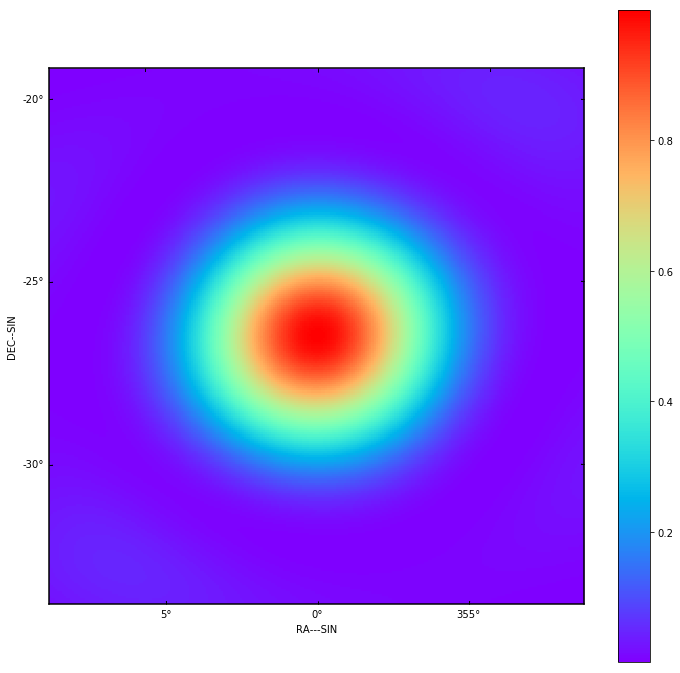

In [6]:
beam=create_low_test_beam(model)
model.data*=beam.data
show_image(beam)
mask = copy_image(beam)
mask.data[beam.data>0.1]=1.0
mask.data[beam.data<=0.1]=0.0

create_image_from_array: created image of shape (256, 256), size 0.000 (GB)


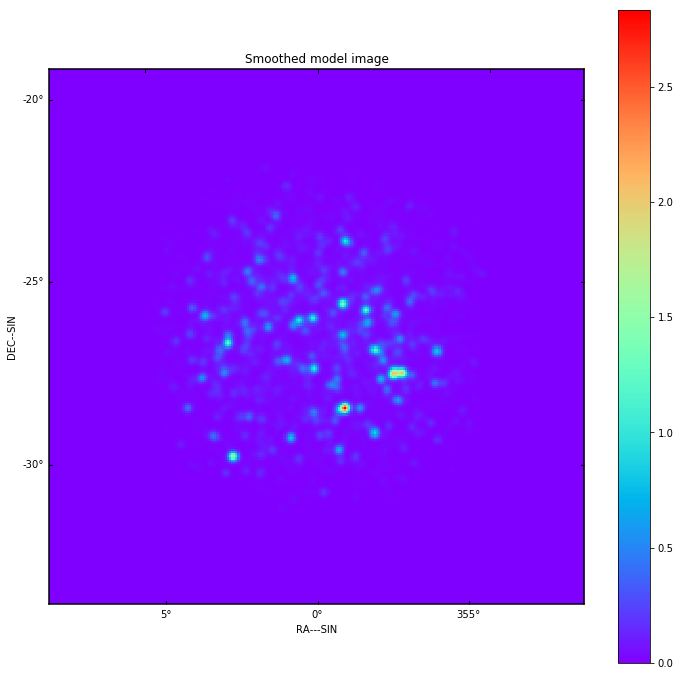

In [7]:
cmodel = create_image_from_array(convolve(model.data[0,0,:,:], Gaussian2DKernel(1.5), normalize_kernel=True), 
                                 model.wcs)
norm = numpy.max(model.data)/numpy.max(cmodel.data)
cmodel.data *= norm
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()

Fit the PSF

In [8]:
psf, sumwt = invert_2d(vt, model, dopsf=True)
psf = normalize_sumwt(psf, sumwt)

invert_2d: inverting using 2d transform
get_uvw_map: effective uv cellsize is 2.0 wavelengths
create_image_from_array: created image of shape (1, 1, 256, 256), size 0.000 (GB)


In [10]:

psf_params = fitgaussian(psf.data[0,0,:,:])

../../arl/misc/gaussian_fit.py:42: RuntimeWarning: invalid value encountered in sqrt
  width_x = np.sqrt(abs((np.arange(col.size) - y) ** 2 * col).sum() / col.sum())
../../arl/misc/gaussian_fit.py:44: RuntimeWarning: invalid value encountered in sqrt
  width_y = np.sqrt(abs((np.arange(row.size) - x) ** 2 * row).sum() / row.sum())


Fill in with the visibility of the model

In [ ]:
vt.data['vis'] *= 0.0
vt.data['uvw'][:,2] = 0


vt = predict_2d(vt, model)

coalesce and plot the uv coverage

In [ ]:
coalescence_factor=1.0

cvt, cindex = coalesce_visibility(vt, coalescence_factor=coalescence_factor, max_coalescence=10)
plt.clf()
plt.plot(+cvt.uvw[:,0],+cvt.uvw[:,1], '.', color='b')
plt.plot(-cvt.uvw[:,0],-cvt.uvw[:,1], '.', color='b')
plt.title('Coalesced uv coverage')
plt.xlabel('U (lambda)')
plt.ylabel('V (lambda)')
plt.show()

Make the dirty images from original and coalesced data

In [ ]:
dirtyimage, sumwt = invert_2d(vt, model)
dirtyimage=normalize_sumwt(dirtyimage, sumwt)
show_image(dirtyimage)
plt.title('Original data image')
plt.show()

cdirtyimage, csumwt=invert_2d(cvt, model)
cdirtyimage=normalize_sumwt(cdirtyimage, csumwt)
show_image(cdirtyimage)
plt.title('Coalesced data image')
plt.show()

Decoalesce and make the dirty image

In [ ]:
dcvt = decoalesce_visibility(cvt, vt, cindex=cindex)

dcdirtyimage, dcsumwt=invert_2d(dcvt, model)
dcdirtyimage=normalize_sumwt(dcdirtyimage, dcsumwt)
show_image(dcdirtyimage)
plt.title('Decoalesced data image')
plt.show()

dcdirtyimage.data -= dirtyimage.data
show_image(dcdirtyimage)
plt.title('Recovery error')
plt.show()

In [ ]:
signal=numpy.std(numpy.abs(vt.vis[:]))
error=numpy.std(numpy.abs(vt.vis[:]-dcvt.vis[:]))
uvdist=numpy.sqrt(vt.u**2+vt.v**2)
plt.clf()
plt.plot(vt.vis.real[:], vt.vis.imag[:], '.', color='b', label='Original')
plt.plot(dcvt.vis.real[:]-vt.vis.real[:], dcvt.vis.imag[:]-vt.vis.imag[:],
         '.', color='r', label='error')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.legend()
plt.title("coalescence = %.3f, rms signal = %.3f, rms error = %.3f" %(coalescence_factor, signal, error))
plt.show()

Now do a range of coalescence factors to see how the recovery error varies. We coalesce and decoalesce and difference the images

In [ ]:
ts = clock()
dirtyimage, sumwt = invert_2d(vt, model)
dirtyimage=normalize_sumwt(dirtyimage, sumwt)
t_full = clock() - ts
show_image(dirtyimage)
plt.show()

qa = qa_image(dirtyimage, mask=mask)
print("Original image", qa)

template_vis = copy_visibility(vt)

signal = []
error_peak = []
error_medianabs = []
t_invert = []
t_coalescees = []
t_decoalescees = []

coalescence_factors = [4.0, 2.0, 1.0, 0.5, 0.25, 0.0]

for coalescence_factor in coalescence_factors:
    ts = clock()
    cvt, cindex = coalesce_visibility(vt, coalescence='tb', coalescence_factor=coalescence_factor, max_coalescence=100)
    t_coalesce = clock() - ts
    t_coalescees.append(t_coalesce)
    log.debug("coalescence using coalescence_factor = %.3f took %.1f seconds" % (coalescence_factor, t_coalesce))

    template_vis.data['vis']*=0.0
    ts = clock()
    dcvt = dcvt = decoalesce_visibility(cvt, vt, cindex=cindex, coalescence='tb')
    t_decoalesce = clock() - ts
    t_decoalescees.append(t_decoalesce)
    log.debug("Decoalescence took %.1f seconds" % (t_decoalesce))
    
    ts = clock()
    dcdirtyimage, dcsumwt=invert_2d(dcvt, model)
    dcdirtyimage=normalize_sumwt(dcdirtyimage, dcsumwt)
    t_invert.append(clock() - ts)

    dcdirtyimage.data -= dirtyimage.data
    show_image(dcdirtyimage)
    plt.title('Recovery error')
    plt.show()
    dcqa = qa_image(dcdirtyimage, mask=mask)
    
    print("Decoalesced coalesced image", dcqa)
    signal.append(qa.data['max'])
    error_peak.append(dcqa.data['max'])
    error_medianabs.append(dcqa.data['medianabs'])
    
    plt.clf()
    plt.plot(vt.vis.real[:], vt.vis.imag[:], '.', color='b', label='Original')
    plt.plot(dcvt.vis.real[:]-vt.vis.real[:], dcvt.vis.imag[:]-vt.vis.imag[:],
         '.', color='r', label='error')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.legend()
    plt.title("coalescence = %.3f" %(coalescence_factor))
    plt.show()

In [ ]:
plt.clf()
plt.semilogy(coalescence_factors, signal, color='r', label='Image peak')
plt.semilogy(coalescence_factors, error_peak, color='b', label='Maximum error in image')
plt.semilogy(coalescence_factors, error_medianabs, color='g', label='Median abs error in image')
plt.title('Error after coalescence and decoalescence')
plt.xlabel('coalescence factor')
plt.ylabel('Error')
plt.legend()
plt.show()
plt.plot(coalescence_factors, t_coalescees, color='r', label='coalescence')
plt.plot(coalescence_factors, t_decoalescees, color='b', label='Decoalescence')
plt.plot(coalescence_factors, t_invert, color='g', label='Invert coalesceed data')
plt.plot(coalescence_factors, numpy.array(t_invert)+numpy.array(t_coalescees), linestyle='dashed',
         color='black', label='coalesce + Invert')
plt.axhline(t_full, color='black', label='Invert full data')
plt.legend()
plt.title('Time for coalesce, decoalesce, and invert')
plt.xlabel('coalescence factor')
plt.ylabel('Time (s)')

plt.show()

